In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn import metrics 
from sklearn.metrics import classification_report

from tensorflow.keras import layers, models
from keras.layers import InputLayer, Activation, merge, Concatenate,Input
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import KFold

In [ ]:
from tensorflow.python.client import  device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5956540202941966033
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3809315434963626145
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import h5py
 
DATA_DIR = "/content/drive/MyDrive/Radar/Radar_5000.mat"
 
data = h5py.File(DATA_DIR,'r')
 
data.keys()

<KeysViewHDF5 ['Data', 'Labels']>

In [ ]:
import numpy as np
 
X = np.transpose(np.array(data['Data']))
Y = np.reshape(np.array(data['Labels']),[-1,])
Xm = np.reshape(X,[len(X),3, 1024,1])
 
print(Xm.shape)
print(Y.shape)
Y = Y - 1
Y = Y.astype(np.int32)
Y.dtype

(45000, 3, 1024, 1)
(45000,)


dtype('int32')

In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, Y_train, Y_test = train_test_split(Xm, Y, test_size=0.1)

In [ ]:
input_shape = (1024,1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
 
# define the model
def define_model(input_shape, num_channels):
    flat_layers = []
    input_layers = []
    ksize = 7
    psize = 5
    for i in range(num_channels):
      inputs = layers.Input(shape=(input_shape))
      #x = layers.BatchNormalization()(inputs)
 
      x = layers.Conv1D(filters=32,kernel_size=ksize, activation='relu')(inputs)
      x = layers.MaxPooling1D(psize)(x)
      x = layers.Conv1D(filters=48,kernel_size=ksize, activation='relu')(x)
      x = layers.Conv1D(filters=64,kernel_size=ksize, activation='relu')(x)
      x = layers.MaxPooling1D(psize)(x)
      x = layers.Conv1D(filters=32,kernel_size=ksize, activation='relu')(x)
      x = layers.Conv1D(filters=128,kernel_size=ksize, activation='relu')(x)
      x = layers.MaxPooling1D(psize)(x)

      #x = layers.Dropout(0.1)(x)
      flat = layers.Flatten()(x)
      #flat = layers.Dense(256, activation='relu')(x)
 
      flat_layers.append(flat)
      input_layers.append(inputs)
   
    # merge
    merged = concatenate(flat_layers)
    # interpretation
    #y = layers.Dense(1024, activation='relu')(merged)
    # y = layers.BatchNormalization()(merged)
    # y = layers.Dense(64, activation='relu')(y)
    # y = layers.Dropout(0.5)(y)
    # y = layers.Dense(16, activation='relu')(y)
    #outputs = layers.Dense(64, activation='relu')(merged)
    output = layers.Dense(9, activation='softmax')(merged)
    model = models.Model(inputs=input_layers, outputs=output)
    # compile
    model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                  optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
    # summarize
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [ ]:
model = define_model(input_shape, 3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1024, 1)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1024, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1018, 32)     256         ['input_1[0][0]']                
                                                                                              

In [ ]:
X_tr = []
X_te = []
 
for i in range(3):
  X_tr.append(X_train[:,i,:,:])
  X_te.append(X_test[:,i,:,:])

In [ ]:
X_tr[0].shape

(40500, 1024, 1)

In [ ]:
history = model.fit(X_tr, Y_train, epochs= 50, shuffle = True,  use_multiprocessing = True,batch_size=128,
                    validation_split=0.10)

Epoch 1/50
285/285 [==============================] - 14s 35ms/step - loss: 1.2260 - accuracy: 0.5252 - val_loss: 0.5967 - val_accuracy: 0.7820
Epoch 2/50
285/285 [==============================] - 7s 24ms/step - loss: 0.4290 - accuracy: 0.8403 - val_loss: 0.2545 - val_accuracy: 0.9037
Epoch 3/50
285/285 [==============================] - 7s 24ms/step - loss: 0.2065 - accuracy: 0.9263 - val_loss: 0.1587 - val_accuracy: 0.9412
Epoch 4/50
285/285 [==============================] - 7s 24ms/step - loss: 0.1231 - accuracy: 0.9566 - val_loss: 0.0725 - val_accuracy: 0.9746
Epoch 5/50
285/285 [==============================] - 7s 25ms/step - loss: 0.0895 - accuracy: 0.9680 - val_loss: 0.0508 - val_accuracy: 0.9815
Epoch 6/50
285/285 [==============================] - 7s 25ms/step - loss: 0.0720 - accuracy: 0.9758 - val_loss: 0.0754 - val_accuracy: 0.9733
Epoch 7/50
285/285 [==============================] - 7s 24ms/step - loss: 0.0485 - accuracy: 0.9827 - val_loss: 0.0478 - val_accuracy: 0.984

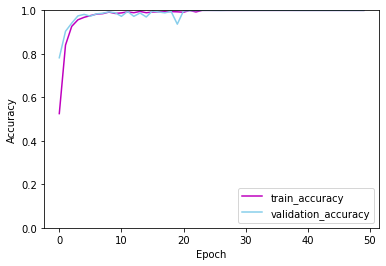

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy',C="m")
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy',C="skyblue")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
#plt.savefig('/content/drive/MyDrive/Radal_models/Radar_Accyracy.png')

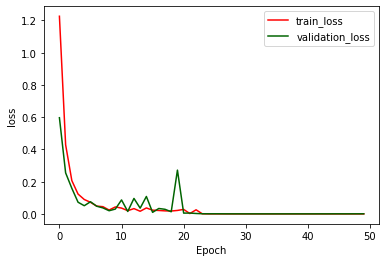

In [ ]:
plt.plot(history.history['loss'], label='train_loss',C='r')
plt.plot(history.history['val_loss'], label = 'validation_loss',C="darkgreen")
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

141/141 - 2s - loss: 9.6975e-04 - accuracy: 0.9998 - 2s/epoch - 11ms/step
test accuracy = 99.97777777777777 %

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       494
           1       1.00      1.00      1.00       494
           2       1.00      1.00      1.00       483
           3       1.00      1.00      1.00       512
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       504
           6       1.00      1.00      1.00       515
           7       1.00      1.00      1.00       528
           8       1.00      1.00      1.00       470

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



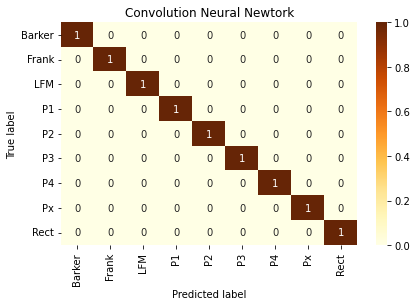

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn import metrics 
from sklearn.metrics import classification_report
 
test_loss, test_acc = model.evaluate(X_te,  Y_test, verbose=2)
Y_te = np.array(tf.math.argmax(model.predict(X_te), 1))
cm = tf.math.confusion_matrix(Y_test, Y_te)
 
 
acc = metrics.accuracy_score(Y_test, Y_te)
print("test accuracy =", acc*100,"%\n")
 
print(classification_report(Y_test, Y_te))
 
con_mat = tf.math.confusion_matrix(labels=Y_test, predictions=Y_te).numpy()
 
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
classes = ["Barker", "Frank", "LFM", "P1", "P2", "P3", "P4", "Px", "Rect"]
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure()
sns.heatmap(con_mat_df, annot=True, cmap="YlOrBr")
plt.tight_layout()
plt.title('Convolution Neural Newtork')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#model.save("/content/drive/MyDrive/Radar/Radar_5000.h5")